# Airbnb Fiyat Tahmini DL Algoritması

# Gerekli Kütüphaneler

In [1]:
from __future__ import print_function
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras import metrics
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam, RMSprop
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras.models import load_model


Using TensorFlow backend.


# Verilerin Okunması

In [2]:
listings_df = pd.read_csv('listings.csv')
calendar_df = pd.read_csv('calendar.csv')

# Veri Temizleme ve Analiz İşlemleri

In [3]:
#Veri temizle için yardımcı fonksiyon
def get_day_from_date(row):
    ''' Gün bulma '''
    return int(row['date'].split('-')[2])

def get_month_from_date(row):
    ''' Ay bulma '''
    return int(row['date'].split('-')[1])

def get_year_from_date(row):
    ''' Yıl bulma '''
    return int(row['date'].split('-')[0])

def get_host_since_year(row):
    ''' konaklama yılını bulma '''
    try:
        host_since = int(row['host_since'].split('-')[0])
    except:
        host_since = np.nan
    return host_since

def get_val_from_list(row, column_name, value):
    ''' Kukla sütunları doldurma '''
    val = 0.0
    try:
        vals = row[column_name].replace('[',
                                        '').replace("'", '').replace("]", '').replace('"',
                                        '').replace('{', '').replace('}', '').split(',')
        if value in vals:
            val = 1.0
    except:
        val = 0.0
    return val

def split_list_into_columns(df, column_name, max_dummies_num = 10):
    ''' sütunda bulunan değerleri liste haline getirme örneğin: amenities/kolaylıklar '''
    
    # versetindeki tekil değerleri getirme
    values_dict = {}

    for unique_value in df[column_name].unique(): 
        for value in unique_value.replace('[', '').replace("'",
                                                           '').replace("]", '').replace('"', '').replace('{',
                                                            '').replace('}', '').split(','):
            if value in values_dict:
                values_dict[value] = values_dict[value] + 1
            else:
                values_dict[value] = 0
                
    values_sorted = sorted(values_dict.items(), key=lambda kv: kv[1], reverse = True)
      
     # sütunlara ayırma
    for value in values_sorted[: max_dummies_num]:
        df[column_name + '_' + value[0]] = df.apply(lambda row: get_val_from_list(row, column_name, value[0]),axis=1)
        
    return

def get_extra_people_fee(row):
    ''' fazladan bir kişi geldiğinde sonuç olarak 1 döndürecek '''
    if row['extra_people'] == '$0.00':
        return 0.0
    else:
        return 1.0

#Veri temizleme fonksiyonu
def clean_dataset(listings_df, calendar_df):
    '''
    Girişler
    listings_df - pandas dataframe ilan veri seti 
    calendar_df - pandas dataframe rezervasyon veri seti
    
    Çıktılar
    df - temizlenmiş veri seti, ilan ve rezervasyon veri setlerinin birleştirilmesiyle oluşturulmuştur:
    1. İlişkisiz sütunlar veri setinden kaldırılmıştır;
    2. Tarih verileri ay ve yıl bildirecek şekilde sayısayl hale getirilmiştir.;
    3. içerisinde liste barından sütunlar tekrar sütunlara ayırlarak veri normalizasyonu yapılmıştır.
    4. missing values are imputed with mean or mode.
    '''
    #veri setini birleştirme
    listings_df = listings_df.rename(index=str, columns={"id": "listing_id"})
    df = pd.merge(calendar_df, listings_df, on = 'listing_id')
    
    #ilişkisiz  sütunlarını kaldırma
    columns_to_drop = ['available', 'host_id','host_location','host_acceptance_rate','host_neighbourhood',
               'host_total_listings_count', 'weekly_price', 'monthly_price',
               'security_deposit', 'cleaning_fee', 'calendar_updated',
               'listing_url','last_scraped' ,'scrape_id', 'name', 'summary', 'space', 'description',
               'experiences_offered', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'zipcode',
               'neighborhood_overview', 'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
               'xl_picture_url', 'host_url', 'host_name', 'host_about', 'host_thumbnail_url', 'host_picture_url',
               'city', 'state', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude',
               'is_location_exact', 'square_feet', 'has_availability', 'availability_30',
               'availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped',
               'first_review', 'last_review', 'requires_license', 'license', 'jurisdiction_names', 'price_y',
               'reviews_per_month','host_response_time','host_is_superhost','host_has_profile_pic','host_identity_verified',
               'neighbourhood_group_cleansed','property_type','room_type','bed_type','instant_bookable','cancellation_policy',
               'require_guest_profile_picture','require_guest_phone_verification']
    df = df.drop(columns = columns_to_drop)
    
    #rezervasyon veri setinde tarih olarak gelen sütun değerini gün,ay ve yıl olarak üçe bölerek sayısallaştırma
    df['month'] = df.apply(lambda row: get_month_from_date(row),axis=1)
    df['year'] = df.apply(lambda row: get_year_from_date(row),axis=1)
    df['day'] = df.apply(lambda row: get_day_from_date(row),axis=1)
    df = df.drop(columns = ['date'])
    
    #price_x sütununu kaldırma süreci
    df = df.dropna(subset=['price_x'])
    
    #fiyat sütununu sayısallaştıma
    df['price'] = df['price_x'].astype(str)
    df['price'] = df['price'].str.replace("[$, ]", "").astype("float")
    df = df.drop(columns = ['price_x'])
    
    #host_since tarih alanındaki tarihi sayısallaştırma ve boş verileri kaldırma işlemi
    df['host_since_year'] = df.apply(lambda row: get_host_since_year(row),axis=1)
    df['host_since_year'].fillna(df['host_since_year'].mean(), inplace = True)
    df = df.drop(columns = ['host_since'])
    
    #host_response_rate sütunundaki verileri sayısallaştırma ve boş verileri kaldırma işlemi
    df['host_response_rate_num'] = df['host_response_rate'].astype(str)
    df['host_response_rate_num'] = df['host_response_rate_num'].str.replace("%", "").astype("float")
    df['host_response_rate_num'].fillna(df['host_response_rate_num'].mean(), inplace = True)
    
    df['host_response_rate_buckets'] = pd.qcut(df['host_response_rate_num'], 5, labels=False, duplicates = 'drop')
    
    df = df.drop(columns = ['host_response_rate', 'host_response_rate_num'])
    
    # host_listings_count sütunundaki boş verileri ortalama host_listings_count ile doldurma
    df['host_listings_count'].fillna(df['host_listings_count'].mean(), inplace = True)
    
    #host_verifications kukla sütunun bölünlendirme ve orjinal değerleri kaldırma işlemi
    split_list_into_columns(df, 'host_verifications')
    df = df.drop(columns = ['host_verifications'])
    
    #bathrooms, bedrooms and beds sütunların mode alarak boş verileri doldurma işlemi
    df['bathrooms'] = df['bathrooms'].fillna(df['bathrooms'].mode()[0])
    df['bedrooms'] = df['bedrooms'].fillna(df['bedrooms'].mode()[0])
    df['beds'] = df['beds'].fillna(df['beds'].mode()[0])
    
    #amenities, kukla değişkenlere bölerek orjinal halindeki veriyi silme işlemi
    split_list_into_columns(df, 'amenities')
    df = df.drop(columns = ['amenities'])
    
    #fazladan kişi olması durumunda sonucun 1 olmaması durumunda sonucun 0 olarak ayarlanma işlemi
    df['extra_people_fee'] = df.apply(lambda row: get_extra_people_fee(row),axis=1)
    df = df.drop(columns = ['extra_people'])
    
    #kullanıcıların görüşlerinin verilerinin tutulduğu sütunlardaki boş verilerin doldurulma işlemi
    review_scores_columns = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                         'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                        'review_scores_value']
    for column in review_scores_columns:
        df[column].fillna(df[column].mean(), inplace = True)
    
    return df

In [4]:
# oluştulmuş veri temizle fonksiyonun çağırma ve veriyi temizleyip birleştirme işleminin yapılması
df = clean_dataset(listings_df, calendar_df)

In [5]:
label_col = 'price'
print(df.describe())

         listing_id  host_listings_count   accommodates      bathrooms  \
count  9.345420e+05        934542.000000  934542.000000  934542.000000   
mean   5.305517e+06             8.432040       3.317107       1.257427   
std    2.974821e+06            31.244377       1.997961       0.581368   
min    3.335000e+03             1.000000       1.000000       0.000000   
25%    2.875975e+06             1.000000       2.000000       1.000000   
50%    5.615620e+06             1.000000       2.000000       1.000000   
75%    7.873345e+06             3.000000       4.000000       1.000000   
max    1.034016e+07           502.000000      16.000000       8.000000   

            bedrooms           beds  guests_included  minimum_nights  \
count  934542.000000  934542.000000    934542.000000   934542.000000   
mean        1.284307       1.729342         1.639393        2.446024   
std         0.847055       1.153594         1.267317       19.784246   
min         0.000000       1.000000         0

In [6]:
def train_validate_test_split(df, train_part=.6, validate_part=.2, test_part=.2, seed=None):
    np.random.seed(seed)
    total_size = train_part + validate_part + test_part
    train_percent = train_part / total_size
    validate_percent = validate_part / total_size
    test_percent = test_part / total_size
    perm = np.random.permutation(df.index)
    m = len(df)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = perm[:train_end]
    validate = perm[train_end:validate_end]
    test = perm[validate_end:]
    return train, validate, test

In [7]:
train_size, valid_size, test_size = (70, 30, 0)
kc_train, kc_valid, kc_test = train_validate_test_split(df, 
                              train_part=train_size, 
                              validate_part=valid_size,
                              test_part=test_size,
                              seed=2016)

In [8]:
kc_y_train = df.loc[kc_train, [label_col]]
kc_x_train = df.loc[kc_train, :].drop(label_col, axis=1)
kc_y_valid = df.loc[kc_valid, [label_col]]
kc_x_valid = df.loc[kc_valid, :].drop(label_col, axis=1)

print('Eğitim setinin boyutu   : ', len(kc_x_train))
print('Doğrulama setinin boyutu: ', len(kc_x_valid))
print('Test setinin boyutu     : ', len(kc_test), '(dönüştürülmeyen)')

Eğitim setinin boyutu   :  654179
Doğrulama setinin boyutu:  280362
Test setinin boyutu     :  1 (dönüştürülmeyen)


In [9]:
def norm_stats(df1, df2):
    dfs = df1.append(df2)
    minimum = np.min(dfs)
    maximum = np.max(dfs)
    mu = np.mean(dfs)
    sigma = np.std(dfs)
    return (minimum, maximum, mu, sigma)

In [10]:
def z_score(col, stats):
    m, M, mu, s = stats
    df = pd.DataFrame()
    for c in col.columns:
        df[c] = (col[c]-mu[c])/s[c]
    return df

In [11]:
stats = norm_stats(kc_x_train, kc_x_valid)
arr_x_train = np.array(z_score(kc_x_train, stats))
arr_y_train = np.array(kc_y_train)
arr_x_valid = np.array(z_score(kc_x_valid, stats))
arr_y_valid = np.array(kc_y_valid)

print('Eğitim şekli      :', arr_x_train.shape)
print('Eğitim örnekleri  : ', arr_x_train.shape[0])
print('Onaylama örnekleri: ', arr_x_valid.shape[0])

Eğitim şekli      : (654179, 44)
Eğitim örnekleri  :  654179
Onaylama örnekleri:  280362


In [12]:
def basic_model_1(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(100, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dense(50, activation="relu"))
    t_model.add(Dense(y_size))
    print(t_model.summary())
    t_model.compile(loss='mean_squared_error',
        optimizer=Adam(),
        metrics=[metrics.mae])
    return(t_model)

In [13]:
def basic_model_2(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(100, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(50, activation="relu"))
    t_model.add(Dense(20, activation="relu"))
    t_model.add(Dense(y_size))
    print(t_model.summary())
    t_model.compile(loss='mean_squared_error',
        optimizer=Adam(),
        metrics=[metrics.mae])
    return(t_model)

In [14]:
def basic_model_3(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(80, activation="tanh", kernel_initializer='normal', input_shape=(x_size,)))
    t_model.add(Dropout(0.2))
    t_model.add(Dense(120, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l1(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(20, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(10, activation="relu", kernel_initializer='normal'))
    t_model.add(Dropout(0.0))
    t_model.add(Dense(y_size))
    t_model.compile(
        loss='mean_squared_error',
        optimizer='nadam',
        metrics=[metrics.mae])
    return(t_model)

In [15]:
model = basic_model_3(arr_x_train.shape[1], arr_y_train.shape[1])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                3600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               9720      
_________________________________________________________________
dropout_2 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                2420      
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                210       
__________

In [16]:
epochs = 500
batch_size = 128

print('Epochs: ', epochs)
print('Batch boyutu: ', batch_size)

Epochs:  500
Batch boyutu:  128


In [17]:
keras_callbacks = [
    # ModelCheckpoint('/tmp/keras_checkpoints/model.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', save_best_only=True, verbose=2)
    # ModelCheckpoint('/tmp/keras_checkpoints/model.{epoch:02d}.hdf5', monitor='val_loss', save_best_only=True, verbose=0)
    # TensorBoard(log_dir='/tmp/keras_logs/model_3', histogram_freq=0, write_graph=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None),
    EarlyStopping(monitor='val_mean_absolute_error', patience=20, verbose=0)
]

In [18]:
history = model.fit(arr_x_train, arr_y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    verbose=0, # Change it to 2, if wished to observe execution
    validation_data=(arr_x_valid, arr_y_valid),
    callbacks=keras_callbacks)

In [19]:
train_score = model.evaluate(arr_x_train, arr_y_train, verbose=0)
valid_score = model.evaluate(arr_x_valid, arr_y_valid, verbose=0)

print('Eğitim MAE: ', round(train_score[1], 4), ', Eğitim Kaybı: ', round(train_score[0], 4)) 
print('Test Sonuç doğrulama MAE: ', round(valid_score[1], 4), ', Test Sonuç Kaybı: ', round(valid_score[0], 4))

Eğitim MAE:  14.089 , Eğitim Kaybı:  525.1152
Test Sonuç doğrulama MAE:  14.1855 , Test Sonuç Kaybı:  535.7411


In [20]:
def plot_hist(h, xsize=6, ysize=10):
    # Grafik Hazırlığı
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    fig, axes = plt.subplots(nrows=4, ncols=4, sharex=True)
    
    # MAE Özeti
    plt.subplot(211)
    plt.plot(h['mean_absolute_error'])
    plt.plot(h['val_mean_absolute_error'])
    plt.title('Eğitim vs Test Sonuç Kontrol MAE')
    plt.ylabel('MAE',fontsize=14)
    plt.xlabel('Epoch',fontsize=14)
    plt.legend(['Eğitim', 'Test Sonuç Kontrolü'], loc='upper left')
    
    # Kayıp Özeti
    plt.subplot(212)
    plt.plot(h['loss'])
    plt.plot(h['val_loss'])
    plt.title('Eğitim vs Test Kayıp')
    plt.ylabel('Kayıp',fontsize=14)
    plt.xlabel('Epoch',fontsize=14)
    plt.legend(['Eğitim', 'Test Sonuç Kontrolü'], loc='upper left')
    
    # Grafiklerin çizimi
    plt.draw()
    plt.show()

    return

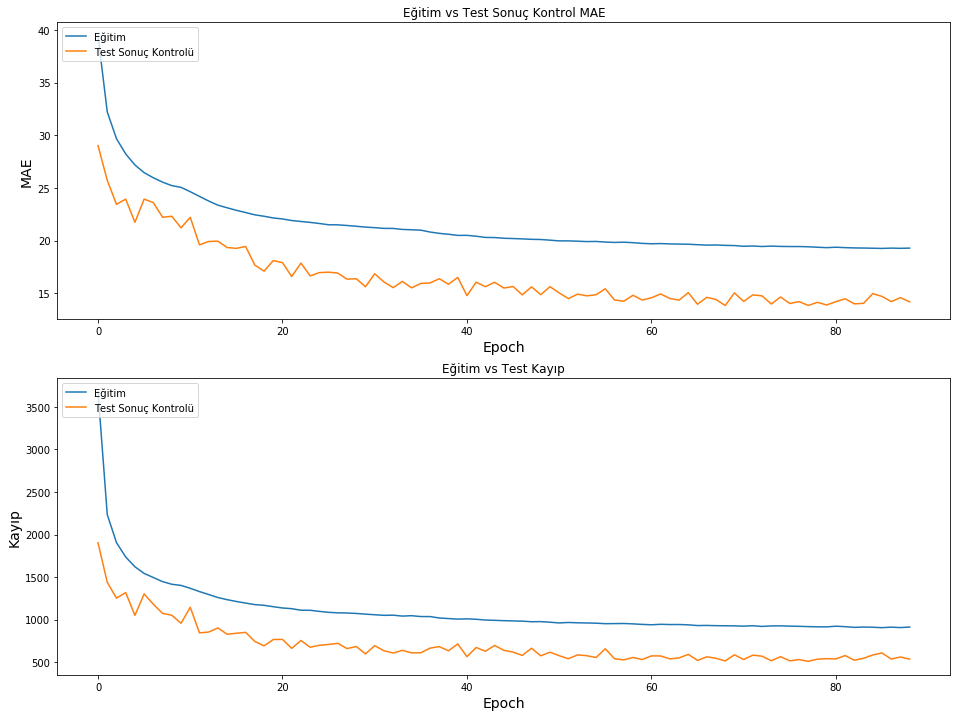

In [21]:
plot_hist(history.history, xsize=16, ysize=12)